BERT 모델 이용

In [ ]:
import os
import re
import math
import numpy as np
import pandas as pd
from random import *
from tqdm import tqdm
from itertools import chain
from collections import Counter

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import pdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pickle

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

In [ ]:
empathy_df = pd.read_csv("/content/drive/MyDrive/Pal-ette/preprocessed_data/empathy_df_total.csv")
# empathy_df = pd.read_csv("/content/empathy_df_total.csv")

# 정서 데이터셋 전체 통합본
# empathy_df = pd.read_csv("/content/drive/MyDrive/Pal-ette/preprocessed_data/emotion-6_merged.csv")
empathy_df.head()

,text,emotion
0,"자기야 나 너무 화가나. 지금 퇴근 후 집에 들어왔는데, 키우는 반려견이 휴지통과 ...",분노
1,오늘 고생하고 집에왔는데 그 장면을 보고 기분이 참 안좋았겠다. 자기가 화나니까 나...,분노
2,"내가 출근 전에 집 청소를 다했었거든. 그런데, 집이 다시 더럽게 되었어. 청소를 ...",분노
3,"나였어도, 아침에 시간 내서 치웠는데, 저녁에 다시 청소를 해야 하면 기분이 안좋을...",분노
4,강아지를 데려온지 얼마 안되서 그런지 힘든게 한두개가 아니야. 밤에는 짖어서 잠을 ...,분노


In [ ]:
empathy_df['emotion'].unique()

array(['분노', '중립', '슬픔', '기쁨', '당황', '불안', '상처'], dtype=object)

LabelEncoder이용

In [ ]:
from sklearn.preprocessing import LabelEncoder

y = empathy_df["emotion"]

# LabelEncoder 객체 생성
encoder = LabelEncoder()
encoder.fit(y)
labels = encoder.transform(y)

print("labels:", labels)

#인코딩 클래스
print("encoder:", encoder.classes_)
#디코딩원본값
print(encoder.inverse_transform(labels))



labels: [2 2 2 ... 3 3 3]
encoder: ['기쁨' '당황' '분노' '불안' '상처' '슬픔' '중립']
['분노' '분노' '분노' ... '불안' '불안' '불안']


In [ ]:
empathy_df['labels'] = labels
empathy_df.tail()

,text,emotion,labels
396724,감정화자님은 자식들이 결혼해 자리를 잡아서 걱정을 안 끼치니 다행이라 생각하셨으면 ...,불안,3
396725,"그렇게 말씀하시니 다행이라는 생각이 들긴 하네요. 얼마 되지는 않지만, 퇴직금이라도...",불안,3
396726,남편분도 오랜 직장 생활에 지쳐서 그러실 거예요. 조금 쉬시다 보면 다시 생각이 달...,불안,3
396727,말씀을 그렇게 희망적으로 해주시니 제 근심이 조금씩 사라지는 기분이네요. 공감화자님...,불안,3
396728,마음을 그렇게 긍정적으로 가지시면 모든 일이 잘 풀릴 거예요. 마음이 건강해야 몸의...,불안,3


라벨 인코딩 이후 전처리

In [ ]:
empathy_df.info() #결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396729 entries, 0 to 396728
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     396729 non-null  object
 1   emotion  396729 non-null  object
 2   labels   396729 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.1+ MB


In [ ]:
empathy_df.columns

Index(['text', 'emotion', 'labels'], dtype='object')

In [ ]:
empathy_df.rename(columns={'preprocessed':'text'}, inplace=True)

In [ ]:
empathy_df['text']

0         자기야 나 너무 화가나. 지금 퇴근 후 집에 들어왔는데, 키우는 반려견이 휴지통과 ...
1         오늘 고생하고 집에왔는데 그 장면을 보고 기분이 참 안좋았겠다. 자기가 화나니까 나...
2         내가 출근 전에 집 청소를 다했었거든. 그런데, 집이 다시 더럽게 되었어. 청소를 ...
3         나였어도, 아침에 시간 내서 치웠는데, 저녁에 다시 청소를 해야 하면 기분이 안좋을...
4         강아지를 데려온지 얼마 안되서 그런지 힘든게 한두개가 아니야. 밤에는 짖어서 잠을 ...
                                ...                        
396724    감정화자님은 자식들이 결혼해 자리를 잡아서 걱정을 안 끼치니 다행이라 생각하셨으면 ...
396725    그렇게 말씀하시니 다행이라는 생각이 들긴 하네요. 얼마 되지는 않지만, 퇴직금이라도...
396726    남편분도 오랜 직장 생활에 지쳐서 그러실 거예요. 조금 쉬시다 보면 다시 생각이 달...
396727    말씀을 그렇게 희망적으로 해주시니 제 근심이 조금씩 사라지는 기분이네요. 공감화자님...
396728    마음을 그렇게 긍정적으로 가지시면 모든 일이 잘 풀릴 거예요. 마음이 건강해야 몸의...
Name: text, Length: 396729, dtype: object

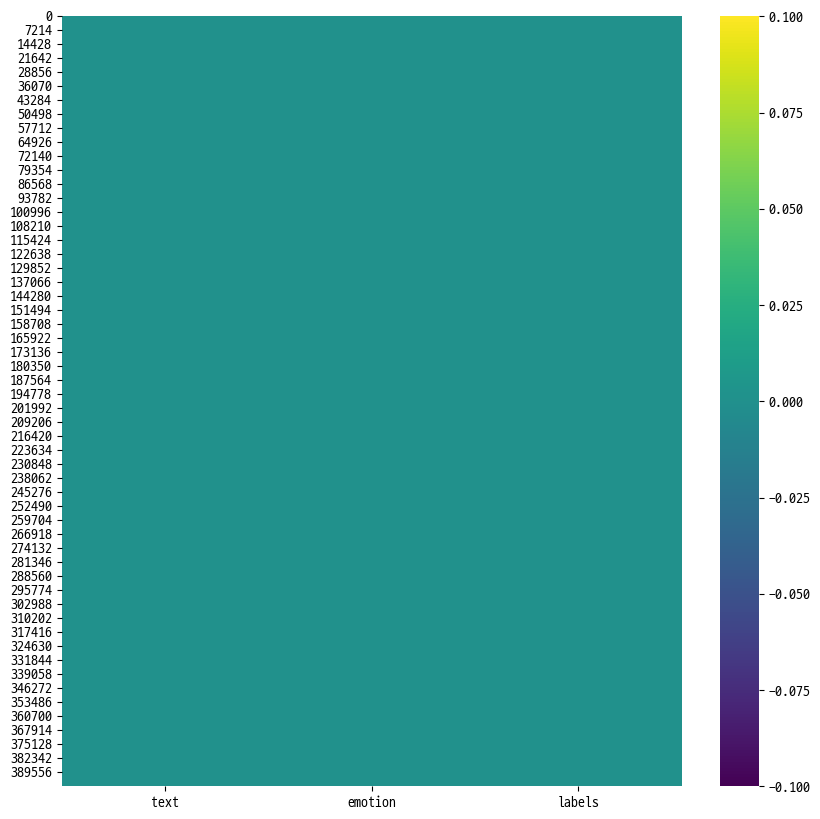

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(empathy_df.isnull(), cmap='viridis')
plt.show()

In [ ]:
empathy_df.isnull().sum()

text       0
emotion    0
labels     0
dtype: int64

In [ ]:
#중복코드 제거
print(empathy_df.duplicated().sum())
duplicated_df = empathy_df.duplicated()

238


In [ ]:
print(empathy_df[duplicated_df])

                                                     text emotion  labels
744             그렇게 말해줘서 고마워, 자기야. 자기 덕분에 기분이 좀 나아진 것 같아.      중립       6
13302   남편, 오늘 나한테 무척 기쁜 일이 있었어. 생각할수록 신이 나고 들떠서 정말 행복...      기쁨       0
13313   내가 우리 아내에게 조금이라도 도움이 되어서 다행이야. 앞으로도 언제든 혼자서 감당...      기쁨       0
13314   그렇게 말해 주는 걸 듣기만 했는데도 마음이 든든해지는 기분이야. 덕분에 기쁨이 배...      기쁨       0
19074   자기 덕분에 마음이 한결 편안해져서 정말 다행이야. 자기의 격려로 인해서 큰 힘이 ...      중립       6
...                                                   ...     ...     ...
394366  공감화자님 잘 지내요? 저 오늘 너무 상처받는 일이 있었어요. 감정화자님도 잘 있죠...      상처       4
394376  그렇게는 생각을 못해 봤어요. 당장 상처받은 마음에만 너무 집중했던 것 같아요. 공...      중립       6
394377  감정화자님 기분이 좋아졌다니 정말 다행이에요. 저도 안도의 미소가 절로 나와요. 감...      상처       4
394378  진작 공감화자님께 고민을 얘기할 걸 그랬어요. 이 고민 탓에 많이 힘들었거든요. 이...      상처       4
394379  제가 도움이 됐다니 기뻐요. 제 소중한 직장동료인 감정화자님의 얘기라면 언제라도 괜...      상처       4

[238 rows x 3 columns]


In [ ]:
empathy_df = empathy_df.drop_duplicates()
empathy_df.duplicated().sum()

0

In [ ]:
stopwords_list = []
# #불용어 사전
# stopwords = "아,휴,아이구,아이쿠,아이고,어,나,우리,저희,따라,의해,을,를,에,의,가,으로,로,에게,뿐이다,의거하여,근거하여,입각하여,기준으로,예하면,예를 들면,예를 들자면,저,소인,소생,저희,지말고,하지마,하지마라,다른,물론,또한,그리고,비길수 없다,해서는 안된다,뿐만 아니라,만이 아니다,만은 아니다,막론하고,관계없이,그치지 않다,그러나,그런데,하지만,든간에,논하지 않다,따지지 않다,설사,비록,더라도,아니면,만 못하다,하는 편이 낫다,불문하고,향하여,향해서,향하다,쪽으로,틈타,이용하여,타다,오르다,제외하고,이 외에,이 밖에,하여야,비로소,한다면 몰라도,외에도,이곳,여기,부터,기점으로,따라서,할 생각이다,하려고하다,이리하여,그리하여,그렇게 함으로써,하지만,일때,할때,앞에서,중에서,보는데서,으로써,로써,까지,해야한다,일것이다,반드시,할줄알다,할수있다,할수있어,임에 틀림없다,한다면,등,등등,제,겨우,단지,다만,할뿐,딩동,댕그,대해서,대하여,대하면,훨씬,얼마나,얼마만큼,얼마큼,남짓,여,얼마간,약간,다소,좀,조금,다수,몇,얼마,지만,하물며,또한,그러나,그렇지만,하지만,이외에도,대해 말하자면,뿐이다,다음에,반대로,반대로 말하자면,이와 반대로,바꾸어서 말하면,바꾸어서 한다면,만약,그렇지않으면,까악,툭,딱,삐걱거리다,보드득,비걱거리다,꽈당,응당,해야한다,에 가서,각,각각,여러분,각종,각자,제각기,하도록하다,와,과,그러므로,그래서,고로,한 까닭에,하기 때문에,거니와,이지만,대하여,관하여,관한,과연,실로,아니나다를가,생각한대로,진짜로,한적이있다,하곤하였다,하,하하,허허,아하,거바,와,오,왜,어째서,무엇때문에,어찌,하겠는가,무슨,어디,어느곳,더군다나,하물며,더욱이는,어느때,언제,야,이봐,어이,여보시오,흐흐,흥,휴,헉헉,헐떡헐떡,영차,여차,어기여차,끙끙,아야,앗,아야,콸콸,졸졸,좍좍,뚝뚝,주룩주룩,솨,우르르,그래도,또,그리고,바꾸어말하면,바꾸어말하자면,혹은,혹시,답다,및,그에 따르는,때가 되어,즉,지든지,설령,가령,하더라도,할지라도,일지라도,지든지,몇,거의,하마터면,인젠,이젠,된바에야,된이상,만큼,어찌됏든,그위에,게다가,점에서 보아,비추어 보아,고려하면,하게될것이다,일것이다,비교적,좀,보다더,비하면,시키다,하게하다,할만하다,의해서,연이서,이어서,잇따라,뒤따라,뒤이어,결국,의지하여,기대여,통하여,자마자,더욱더,불구하고,얼마든지,마음대로,주저하지 않고,곧,즉시,바로,당장,하자마자,밖에 안된다,하면된다,그래,그렇지,요컨대,다시 말하자면,바꿔 말하면,즉,구체적으로,말하자면,시작하여,시초에,이상,허,헉,허걱,바와같이,해도좋다,해도된다,게다가,더구나,하물며,와르르,팍,퍽,펄렁,동안,이래,하고있었다,이었다,에서,로부터,까지,예하면,했어요,해요,함께,같이,더불어,마저,마저도,양자,모두,습니다,가까스로,하려고하다,즈음하여,다른,다른 방면으로,해봐요,습니까,했어요,말할것도 없고,무릎쓰고,개의치않고,하는것만 못하다,하는것이 낫다,매,매번,들,모,어느것,어느,로써,갖고말하자면,어디,어느쪽,어느것,어느해,어느 년도,라 해도,언젠가,어떤것,어느것,저기,저쪽,저것,그때,그럼,그러면,요만한걸,그래,그때,저것만큼,그저,이르기까지,할 줄 안다,할 힘이 있다,너,너희,당신,어찌,설마,차라리,할지언정,할지라도,할망정,할지언정,구토하다,게우다,토하다,메쓰겁다,옆사람,퉤,쳇,의거하여,근거하여,의해,따라,힘입어,그,다음,버금,두번째로,기타,첫번째로,나머지는,그중에서,견지에서,형식으로 쓰여,입장에서,위해서,단지,의해되다,하도록시키다,뿐만아니라,반대로,전후,전자,앞의것,잠시,잠깐,하면서,그렇지만,다음에,그러한즉,그런즉,남들,아무거나,어찌하든지,같다,비슷하다,예컨대,이럴정도로,어떻게,만약,만일,위에서 서술한바와같이,인 듯하다,하지 않는다면,만약에,무엇,무슨,어느,어떤,아래윗,조차,한데,그럼에도 불구하고,여전히,심지어,까지도,조차도,하지 않도록,않기 위하여,때,시각,무렵,시간,동안,어때,어떠한,하여금,네,예,우선,누구,누가 알겠는가,아무도,줄은모른다,줄은 몰랏다,하는 김에,겸사겸사,하는바,그런 까닭에,한 이유는,그러니,그러니까,때문에,그,너희,그들,너희들,타인,것,것들,너,위하여,공동으로,동시에,하기 위하여,어찌하여,무엇때문에,붕붕,윙윙,나,우리,엉엉,휘익,윙윙,오호,아하,어쨋든,만 못하다,하기보다는,차라리,하는 편이 낫다,흐흐,놀라다,상대적으로 말하자면,마치,아니라면,쉿,그렇지 않으면,그렇지 않다면,안 그러면,아니었다면,하든지,아니면,이라면,좋아,알았어,하는것도,그만이다,어쩔수 없다,하나,일,일반적으로,일단,한켠으로는,오자마자,이렇게되면,이와같다면,전부,한마디,한항목,근거로,하기에,아울러,하지 않도록,않기 위해서,이르기까지,이 되다,로 인하여,까닭으로,이유만으로,이로 인하여,그래서,이 때문에,그러므로,그런 까닭에,알 수 있다,결론을 낼 수 있다,으로 인하여,있다,어떤것,관계가 있다,관련이 있다,연관되다,어떤것들,에 대해,이리하여,그리하여,여부,하기보다는,하느니,하면 할수록,운운,이러이러하다,하구나,하도다,다시말하면,다음으로,에 있다,에 달려 있다,우리,우리들,오히려,하기는한데,어떻게,어떻해,어찌됏어,어때,어째서,본대로,자,이,이쪽,여기,이것,이번,이렇게말하자면,이런,이러한,이와 같은,요만큼,요만한 것,얼마 안 되는 것,이만큼,이 정도의,이렇게 많은 것,이와 같다,이때,이렇구나,것과 같이,끼익,삐걱,따위,와 같은 사람들,부류의 사람들,왜냐하면,중의하나,오직,오로지,에 한하다,하기만 하면,도착하다,까지 미치다,도달하다,정도에 이르다,할 지경이다,결과에 이르다,관해서는,여러분,하고 있다,한 후,혼자,자기,자기집,자신,우에 종합한것과같이,총적으로 보면,총적으로 말하면,총적으로,대로 하다,으로서,참,그만이다,할 따름이다,쿵,탕탕,쾅쾅,둥둥,봐,봐라,아이야,아니,와아,응,아이,참나,년,월,일,령,영,일,이,삼,사,오,육,륙,칠,팔,구,이천육,이천칠,이천팔,이천구,하나,둘,셋,넷,다섯,여섯,일곱,여덟,아홉,령,영,이,있,하,것,들,그,되,수,이,보,나,사람,주,아니,등,같,우리,때,년,가,한,지,대하,오,말,그렇,위하,때문,그것,두,말하,알,그러나,받,못하,일,그런,또,문제,더,사회,많,그리고,좋,크,따르,중,나오,가지,씨,시키,만들,지금,생각하,그러,속,하나,집,살,모르,적,월,데,자신,어떤,내,경우,명,생각,시간,그녀,다시,이런,앞,보이,번,나,다른,어떻,여자,개,전,들,사실,이렇,점,싶,말,정도,좀,원,잘,통하,놓"
# # 불용어들을 공백을 기준으로 분리하여 리스트로 변환
# stopwords_list = stopwords.split(",")
# stopwords_list

In [ ]:
def text_preprocessing(text):
    # 기호 제거
    text = re.sub('[^가-힣]', ' ', text)
    # 불용어 처리
    text = [word for word in text.split() if word not in stopwords_list]
    text = ' '.join(text)
    return text

In [ ]:
text_preprocessing("아이고 배야")

'아이고 배야'

In [ ]:
sample = empathy_df['text'][2]
print(sample)
print('='*20)
print(text_preprocessing(sample))

내가 출근 전에 집 청소를 다했었거든. 그런데, 집이 다시 더럽게 되었어. 청소를 다시 할 생각하니 너무 기분이 안좋고 화가나네. 나였어도, 아침에 시간 내서 치웠는데, 저녁에 다시 청소를 해야 하면 기분이 안좋을 것 같아. 나도 키우는 강아지로 인해 청소를 여러 번 하고 있거든. 번거롭기도 하고 귀찮기도 해서 더 기분이 안좋다는 거 잘 알고 있어.
내가 출근 전에 집 청소를 다했었거든 그런데 집이 다시 더럽게 되었어 청소를 다시 할 생각하니 너무 기분이 안좋고 화가나네 나였어도 아침에 시간 내서 치웠는데 저녁에 다시 청소를 해야 하면 기분이 안좋을 것 같아 나도 키우는 강아지로 인해 청소를 여러 번 하고 있거든 번거롭기도 하고 귀찮기도 해서 더 기분이 안좋다는 거 잘 알고 있어


In [ ]:
empathy_df['cleaned_text'] = empathy_df['text'].apply(text_preprocessing)
empathy_df.head()

,text,emotion,labels,cleaned_text
0,"자기야 나 너무 화가나. 지금 퇴근 후 집에 들어왔는데, 키우는 반려견이 휴지통과 ...",분노,2,자기야 나 너무 화가나 지금 퇴근 후 집에 들어왔는데 키우는 반려견이 휴지통과 봉투...
1,오늘 고생하고 집에왔는데 그 장면을 보고 기분이 참 안좋았겠다. 자기가 화나니까 나...,분노,2,오늘 고생하고 집에왔는데 그 장면을 보고 기분이 참 안좋았겠다 자기가 화나니까 나도...
2,"내가 출근 전에 집 청소를 다했었거든. 그런데, 집이 다시 더럽게 되었어. 청소를 ...",분노,2,내가 출근 전에 집 청소를 다했었거든 그런데 집이 다시 더럽게 되었어 청소를 다시 ...
3,"나였어도, 아침에 시간 내서 치웠는데, 저녁에 다시 청소를 해야 하면 기분이 안좋을...",분노,2,나였어도 아침에 시간 내서 치웠는데 저녁에 다시 청소를 해야 하면 기분이 안좋을 것...
4,강아지를 데려온지 얼마 안되서 그런지 힘든게 한두개가 아니야. 밤에는 짖어서 잠을 ...,분노,2,강아지를 데려온지 얼마 안되서 그런지 힘든게 한두개가 아니야 밤에는 짖어서 잠을 설...


<Axes: xlabel='emotion', ylabel='count'>

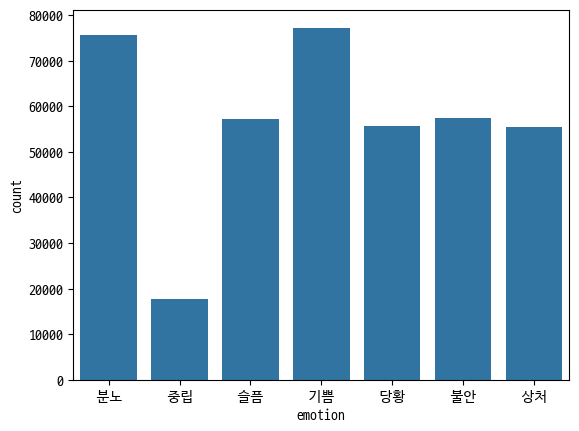

In [ ]:
sns.countplot(x=empathy_df['emotion'])

In [ ]:
corpus = [word for text in empathy_df['cleaned_text'] for word in text.split()]

count_words = Counter(corpus)

sorted_words = count_words.most_common(20)
sorted_words

[('너무', 186229),
 ('것', 174143),
 ('정말', 148071),
 ('수', 107199),
 ('내가', 100907),
 ('같아', 98597),
 ('더', 98421),
 ('마음이', 97269),
 ('거야', 89786),
 ('안', 88428),
 ('잘', 86743),
 ('그', 86125),
 ('게', 80206),
 ('그런', 74695),
 ('많이', 72706),
 ('네가', 71158),
 ('그렇게', 67543),
 ('내', 62814),
 ('나도', 60687),
 ('거', 59314)]

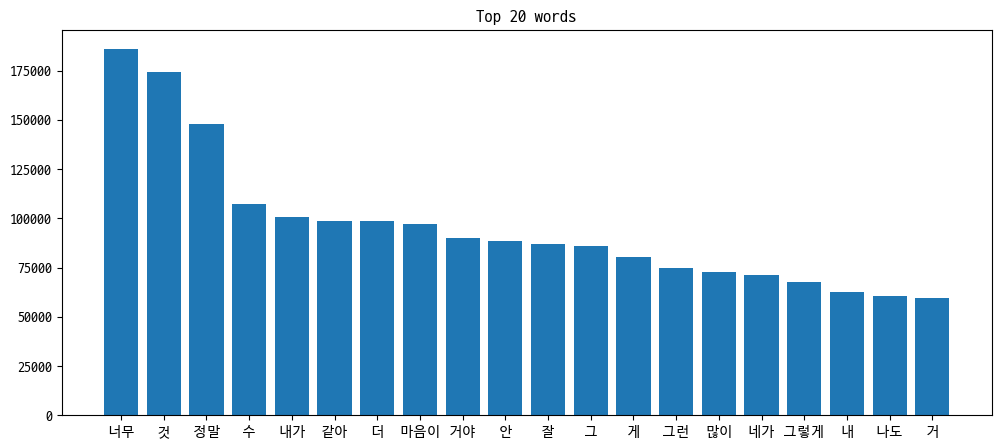

In [ ]:
keys = []
values = []

for key, value in sorted_words[:20]:

    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 words')
plt.show()

In [ ]:
def create_vocab_and_tokenize(reviews, min_freq=0, max_length=64):
    # 리뷰를 토큰화합니다.
    def tokenize_text(text):
        return text.split()

    tokenized_reviews = [tokenize_text(review) for review in reviews]

    # 각 토큰의 발생 횟수를 세어봅니다.
    token_counts = Counter(chain(*tokenized_reviews))

    # min_freq 이상 출현한 토큰만으로 어휘를 만듭니다.
    vocab = {token: i for i, (token, count) in enumerate(token_counts.items()) if count >= min_freq}

    #어휘에 특수 토큰을 추가합니다
    vocab = {**{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3}, **vocab}

    # 리뷰를 입력 ID와 attention masks로 변환합니다.
    input_ids = []
    attention_masks = []

    for review in reviews:
        # 리뷰를 토큰화하고 최대 길이에 맞게 잘라냅니다.
        tokens = tokenize_text(review)[:max_length-2]
        input_id = [2] + [vocab.get(token, 1) for token in tokens] + [3]

        attention_mask = [1] * len(input_id) + [0] * (max_length - len(input_id))
        input_id += [0] * (max_length - len(input_id))
        input_ids.append(input_id)
        attention_masks.append(attention_mask)

    return vocab, torch.tensor(input_ids), torch.tensor(attention_masks)

In [ ]:
text = empathy_df['cleaned_text'].tolist()
emotions = empathy_df['labels'].tolist()

In [ ]:
vocab, input_ids, attention_masks = create_vocab_and_tokenize(text)

# # a temporary list
# temp_list = y

# # dictionary that maps integer to its string value
# label_dict = {}

# # list to store integer labels
# emotions_int_labels = []

# for i in range(len(temp_list)):
#     label_dict[i] = temp_list[i]
#     emotions_int_labels.append(i)


emotions = torch.tensor(emotions)

input_ids = input_ids.type(torch.LongTensor)
input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

emotions = emotions.type(torch.LongTensor)
emotions = emotions.to(device)

# labels = labels.type(torch.LongTensor) # <---- Here (casting)
# labels = labels.to(device)

In [ ]:
#데이터셋 생성
dataset = TensorDataset(input_ids, attention_masks, emotions)

# 90%를 train 10%는 validation 사용
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
#random_split 데이터셋 무작위 분할
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size = 64
#훈련데이터를 위한 데이터 로더
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),  # 무작위 샘플링
    batch_size = batch_size
)
#검증 데이터를 위한 데이터 로더
validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),  # 순차적 샘플링
    batch_size = batch_size
)

In [ ]:
len(vocab)

354891

In [ ]:
maxlen = 512
vocab_size = len(vocab)
max_pred = 20

n_layers = 12
n_heads = 8
d_model = 768
d_ff = 768*4
d_k = d_v = 64

n_segments = 2
lr = 0.0001
epochs = 200

dropout = 0.1

early_stopping_max = 10

In [ ]:
def gelu(x):
  return x *0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.tok_embedding = nn.Embedding(vocab_size, d_model) # 토큰임베딩 : 주어진 단어나 토큰을 d_model 차원의 벡터로 변환
        self.pos_embedding = nn.Embedding(maxlen, d_model) # 위치 임베딩 :  각 토큰의 위치를  d_model 차원의 벡터로 변환
        self.norm = nn.LayerNorm(d_model) # LayerNorm : 임베딩 벡터를 정규화
        self.dropout = nn.Dropout(dropout) #모델 과적합 방지

    def forward(self, x):
        seq_len = x.size(1) #입력 시퀀스의 길이를 가져옴
        #입력 x의 각 토큰에 대한 위치 정보를 생성
        pos = torch.arange(seq_len,dtype = torch.long, device = x.device)
        pos = pos.unsqueeze(0).repeat(x.size(0), 1)

        #토큰임베딩과 위치임베팅을 합침
        embedding = self.tok_embedding(x) + self.pos_embedding(pos)

        return self.dropout(self.norm(embedding))

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([d_model//n_heads])).to(device)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.w_q(query)
        K = self.w_k(key)
        V = self.w_v(value)

        Q = Q.view(batch_size, -1, n_heads, d_model//n_heads).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, n_heads, d_model//n_heads).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, n_heads, d_model//n_heads).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = self.dropout(self.softmax(energy))

        X = torch.matmul(attention, V)
        X = X.permute(0, 2, 1, 3).contiguous()
        X = X.view(batch_size, -1, d_model)

        X = self.fc(X)

        return X


In [ ]:
class PositionwiseFeedforward(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(d_model, d_ff, 1)
        self.conv2 = nn.Conv1d(d_ff, d_model, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x => [batch_size, seq_len, d_model]
        x = x.permute(0, 2, 1)
        x = self.dropout(gelu(self.conv1(x)))

        x = self.conv2(x)

        x = x.permute(0, 2, 1)

        return x
      #fc1, fc2대신.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_self_attn = MultiHeadAttention()
        self.encoder_feed_fwd = PositionwiseFeedforward()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, input_mask=None):
    # input => [batch_size, seq_len, d_model]

      encoder_outputs = self.layer_norm(input + self.dropout(self.encoder_self_attn(input, input, input, input_mask)))
      encoder_outputs = self.layer_norm(encoder_outputs + self.dropout(self.encoder_feed_fwd(encoder_outputs)))
      return encoder_outputs

In [ ]:
class Bert(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        self.embedding = Embedding(vocab_size)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, d_model)
        self.activn = gelu
        self.norm = nn.LayerNorm(d_model)

        # outfeature 개수 조정
        # merged_dataset: '분노', '슬픔', '기쁨', '당황', '불안', '상처'
        # empathy_dataset: '분노', '슬픔', '기쁨', '당황', '불안', '상처', '중립'
        self.classifier = nn.Linear(d_model, 7)

    def forward(self, input_ids, attention_mask):
        # 임베딩 레이어를 통과
        embedding_output = self.embedding(input_ids)
        # 각 인코더 레이어를 순차적으로 통과
        for layer in self.layers:
            encoder_output = layer(embedding_output)
        pooled_output = encoder_output[:, 0]
        # 분류를 위해 선형 레이어를 통과
        output = self.classifier(pooled_output)

        return output

In [ ]:
model = Bert(vocab_size)
model = model.to(device)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)

Bert(
  (embedding): Embedding(
    (tok_embedding): Embedding(354891, 768)
    (pos_embedding): Embedding(512, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-11): 12 x EncoderLayer(
      (encoder_self_attn): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc): Linear(in_features=768, out_features=768, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (encoder_feed_fwd): PositionwiseFeedforward(
        (conv1): Conv1d(768, 3072, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(3072, 768, kernel_size=(1,), stride=(1,))
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_af

In [ ]:
def train_and_validate(
    model, train_dataloader, validation_dataloader, epochs, optimizer, criterion
):
    acc_early_counter = 0
    best_val_accuracy, best_val_loss = 0.0, 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 10)

        model.train()
        total_loss = 0
        train_preds, train_labels = [], []

        progress_bar = tqdm(train_dataloader, desc="Training", position=0, leave=True)
        for step, batch in enumerate(progress_bar):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)

            # 그래디언트 초기화
            model.zero_grad()

            outputs = model(b_input_ids, b_input_mask)

            # 손실계산
            loss = criterion(outputs.squeeze(), b_labels.long())
            # loss = criterion(outputs.squeeze(), b_labels.float())
            total_loss += loss.item()

            # 그래디언트 역전파
            loss.backward()

            # 그래디언트 클리핑 - 폭발방지
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # 모델 파라미터 업데이트
            optimizer.step()

            # 예측값 레이블 저장
            softmax_probs = torch.nn.functional.softmax(outputs, dim=1)
            train_preds.extend(softmax_probs.squeeze().detach().cpu().numpy().tolist())
            # train_preds.extend(torch.sigmoid(outputs).squeeze().detach().cpu().numpy().tolist())
            train_labels.extend(b_labels.squeeze().detach().cpu().numpy().tolist())

            # 진행바 업데이트
            progress_bar.set_postfix(
                {"training_loss": "{:.3f}".format(loss.item() / len(train_dataloader))}
            )

        # 평균학습손실
        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # (바이너리) 학습 정확도 측정
        # train_preds = [1 if pred > 0.5 else 0 for pred in train_preds]
        # train_acc = accuracy_score(train_labels, train_preds)
        # print(f"Train Accuracy: {train_acc:.4f}")

        # train_preds를 텐서로 변환
        # train_preds에서 각 샘플에 대한 최대값을 가지는 클래스 찾기
        predicted_classes = torch.argmax(torch.tensor(train_preds), axis=1)

        # 실제 레이블과 비교하여 정확도 계산
        train_labels_numpy = np.array([label for label in train_labels])
        train_preds_numpy = (
            predicted_classes.numpy()
        )  # 예측된 클래스를 넘파이 배열로 변환

        # 정확도 계산
        train_acc = accuracy_score(train_labels_numpy, train_preds_numpy)
        print(f"Train Accuracy: {train_acc:.4f}")

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # 검증모드 설정
        model.eval()
        total_eval_loss = 0
        val_preds, val_labels = [], []

        # 검증데이터로 검증 진행
        progress_bar = tqdm(
            validation_dataloader, desc="Validation", position=0, leave=True
        )
        for step, batch in enumerate(progress_bar):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)

            # 그래디언트 계산 비활성화
            with torch.no_grad():
                outputs = model(b_input_ids, b_input_mask)

                # 손실계산
                loss = criterion(outputs.squeeze(), b_labels.long())
                total_eval_loss += loss.item()

                # 예측값 및 레이블 저장

                softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                val_preds.extend(
                    softmax_probs.squeeze().detach().cpu().numpy().tolist()
                )
                val_labels.extend(b_labels.squeeze().detach().cpu().numpy().tolist())

                # 진행바 업데이트
                progress_bar.set_postfix(
                    {"validation_loss": "{:.3f}".format(loss.item() / len(batch))}
                )

        # 평균검증손실

        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # train_preds에서 각 샘플에 대한 최대값을 가지는 클래스 찾기
        val_predicted_classes = torch.argmax(torch.tensor(val_preds), axis=1)

        # 실제 레이블과 비교하여 정확도 계산
        val_labels_numpy = np.array([label for label in val_labels])
        val_preds_numpy = (
            val_predicted_classes.numpy()
        )  # 예측된 클래스를 넘파이 배열로 변환

        # 검증 정확도 측정 val_preds = [1 if pred > 0.5 else 0 for pred in val_preds]
        val_acc = accuracy_score(val_labels_numpy, val_preds_numpy)
        print(f"Validation Accuracy: {val_acc:.4f}")

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_accuracy:
            acc_early_counter = 0
            best_val_accuracy = val_acc
            # Save the model if the current validation accuracy is the best
            file_name = f"/content/drive/MyDrive/Pal-ette/trained_models/datamerged_model_acc_{epoch}_{int(val_acc*100)}.pth"
            if not os.path.exists(file_name):
                print("File does not exist.")
                with open(file_name, "w") as f:
                    pass

            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_val_loss,
                },
                file_name,
            )
            print(f"Model saved: Improved validation accuracy to {val_acc:.4f}")
        else:
            acc_early_counter += 1
            if acc_early_counter > early_stopping_max:
                print("Early stopping triggered")
                break

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            file_name = f"/content/drive/MyDrive/Pal-ette/trained_models/datamerged_model_loss_{epoch}_{int(avg_val_loss*100)}.pth"
            if not os.path.exists(file_name):
                print("File does not exist.")
                with open(file_name, "w") as f:
                    pass

            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_val_loss,
                },
                file_name,
            )
            print(f"Model saved: Improved loss {avg_val_loss:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, train_dataloader, validation_dataloader, epochs, optimizer, criterion)

Epoch 1/200
----------


Training: 100%|██████████| 5576/5576 [11:44<00:00,  7.91it/s, training_loss=0.000]


Average training loss: 1.2017
Train Accuracy: 0.5487


Validation: 100%|██████████| 620/620 [00:47<00:00, 13.17it/s, validation_loss=0.459]


Validation Accuracy: 0.6353
File does not exist.
Model saved: Improved validation accuracy to 0.6353
Epoch 2/200
----------


Training: 100%|██████████| 5576/5576 [11:46<00:00,  7.89it/s, training_loss=0.000]


Average training loss: 0.9830
Train Accuracy: 0.6457


Validation: 100%|██████████| 620/620 [00:46<00:00, 13.21it/s, validation_loss=0.416]


Validation Accuracy: 0.6764
File does not exist.
Model saved: Improved validation accuracy to 0.6764
Epoch 3/200
----------


Training: 100%|██████████| 5576/5576 [11:45<00:00,  7.90it/s, training_loss=0.000]


Average training loss: 0.8998
Train Accuracy: 0.6790


Validation: 100%|██████████| 620/620 [00:47<00:00, 13.18it/s, validation_loss=0.398]


Validation Accuracy: 0.6961
File does not exist.
Model saved: Improved validation accuracy to 0.6961
Epoch 4/200
----------


Training: 100%|██████████| 5576/5576 [11:46<00:00,  7.89it/s, training_loss=0.000]


Average training loss: 0.8377
Train Accuracy: 0.7033


Validation: 100%|██████████| 620/620 [00:47<00:00, 13.17it/s, validation_loss=0.361]


Validation Accuracy: 0.7100
File does not exist.
Model saved: Improved validation accuracy to 0.7100
Epoch 5/200
----------


Training: 100%|██████████| 5576/5576 [11:46<00:00,  7.90it/s, training_loss=0.000]


Average training loss: 0.7870
Train Accuracy: 0.7235


Validation: 100%|██████████| 620/620 [00:47<00:00, 13.18it/s, validation_loss=0.321]


Validation Accuracy: 0.7212
File does not exist.
Model saved: Improved validation accuracy to 0.7212
Epoch 6/200
----------


Training:  41%|████      | 2267/5576 [04:47<06:56,  7.95it/s, training_loss=0.000]

In [ ]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.title('Loss over epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Train Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.title('Accuracy over epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

In [ ]:
PATH = file_name

In [ ]:
model = Bert(vocab_size)
model.load_state_dict(torch.load(PATH, map_location=device))

In [ ]:
model.eval()

In [ ]:
new_reviews = [
    "차선을 이상하게 변경하는 사람이 있어서 아침부터 욕을 했어. 두차선을 가로지르는게 말이된다고 생각해??",
    "기분이 너무 좋아",
    "오다가 넘어져서 피부가 까졌어",
    "나 오늘 슬퍼, 위로해줘",
    "나 속상해",
    "너 늦게오지마",
    "엉엉 울었어"
  ]

# 최소 발생 빈도수와 최대 텍스트 길이 설정
min_frequency = 1
max_text_length = 64

# 어휘와 토큰화된 입력 데이터 생성
vocab, input_ids, attention_masks = create_vocab_and_tokenize(new_reviews, min_freq=min_frequency, max_length=max_text_length)
# print(vocab)
# print(input_ids)
# print(attention_masks)

# 입력 데이터를 모델에 넣어 예측 수행
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)
    predictions = torch.argmax(outputs, dim=-1)
    print(outputs)

# 결과 출력
print("Predictions:", [['분노', '슬픔', '기쁨', '당황', '불안', '상처'][p] for p in predictions])

In [ ]:
# (['분노', '슬픔', '기쁨', '당황', '불안', '상처']
